In [206]:
from scipy import sparse
from os import listdir
import numpy as np

chrom = '22'
data_dir = '../split_gen'
dp_dir = '../split_dp'

In [207]:
# use only "cleaned" variants - must be SNPs and missingness in parents can't be sex-biased
snp_indices = []
snp_positions = []
clean_file = '%s/clean_indices_%s.txt' % (data_dir, chrom) 
with open(clean_file, 'r') as f:
    for i, line in enumerate(f):
        index, position = line.strip().split('\t')
        snp_indices.append(int(index))
        snp_positions.append(int(position))
snp_positions = np.array(snp_positions)
pos_to_index = dict([(x, i) for i, x in enumerate(snp_positions)])

In [208]:
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s' % chrom) in f and 'gen.npz' in f])

# pull genotype data from .npz
whole_chrom = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file)) for gen_file in gen_files])
whole_chrom = whole_chrom[:, snp_indices]
m, n = whole_chrom.shape
print('chrom shape only SNPs', m, n)

chrom shape only SNPs 4610 1003938


In [209]:
dp_files = sorted([f for f in listdir(dp_dir) if ('chr.%s' % chrom) in f and 'dp.npz' in f])

# pull dp data from .npz
chrom_dp = sparse.hstack([sparse.load_npz('%s/%s' % (dp_dir, dp_file)) for dp_file in dp_files])
chrom_dp = chrom_dp[:, snp_indices]
m, n = chrom_dp.shape
print('chrom shape', m, n)

chrom shape 4610 1003938


In [210]:
missing_dp, counts = np.unique(chrom_dp[whole_chrom==-1].A, return_counts=True)

In [211]:
het_dp, het_counts = np.unique(chrom_dp[whole_chrom==1].A, return_counts=True)

In [212]:
homalt_dp, homalt_counts = np.unique(chrom_dp[whole_chrom==2].A, return_counts=True)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Missing
Percent with depth>20 0.13305418388179946
Percent with depth<5 0.7975717477927713
Percent with depth<2 0.7577438038213654
Percent with depth=0 0.721454252657719
Homalt
Percent with depth>20 0.9000176434473776
Percent with depth<5 0.015482651573651841
Percent with depth<2 0.0009617040342755857
Percent with depth=0 7.820367840860693e-06
Het
Percent with depth>20 0.9247988743598893
Percent with depth<5 0.0023249965917560675
Percent with depth<2 1.091096959174968e-05
Percent with depth=0 1.0023358894468437e-06


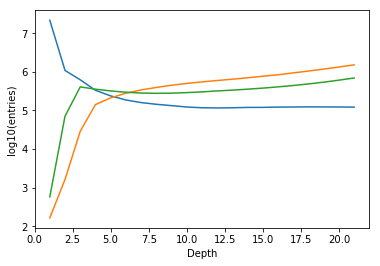

In [213]:
import matplotlib.pyplot as plt

print(missing_dp)

print('Missing')
print('Percent with depth>20', counts[0]/sum(counts))
print('Percent with depth<5', sum(counts[1:6])/sum(counts))
print('Percent with depth<2', sum(counts[1:3])/sum(counts))
print('Percent with depth=0', counts[1]/sum(counts))

print('Homalt')
print('Percent with depth>20', homalt_counts[0]/sum(homalt_counts))
print('Percent with depth<5', sum(homalt_counts[1:6])/sum(homalt_counts))
print('Percent with depth<2', sum(homalt_counts[1:3])/sum(homalt_counts))
print('Percent with depth=0', homalt_counts[1]/sum(homalt_counts))

print('Het')
print('Percent with depth>20', het_counts[0]/sum(het_counts))
print('Percent with depth<5', sum(het_counts[1:6])/sum(het_counts))
print('Percent with depth<2', sum(het_counts[1:3])/sum(het_counts))
print('Percent with depth=0', het_counts[1]/sum(het_counts))

plt.plot(missing_dp[1:], np.log10(counts[1:]))
plt.plot(het_dp[1:], np.log10(het_counts[1:]))
plt.plot(homalt_dp[1:], np.log10(homalt_counts[1:]))
plt.xlabel('Depth')
plt.ylabel('log10(entries)')
plt.show()

In [214]:
ped_file = '../data/160826.ped'
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
# pull families with sequence data
with open(sample_file, 'r') as f:
	sample_ids = [line.strip() for line in f]
sample_id_to_index = dict([(sample_id, i) for i, sample_id in enumerate(sample_ids)])

# pull families from ped file
families = dict()
with open(ped_file, 'r') as f:	
    for line in f:
        pieces = line.strip().split('\t')
        fam_id, child_id, f_id, m_id = pieces[0:4]

        if child_id in sample_ids and f_id in sample_ids and m_id in sample_ids:
        	if (fam_id, m_id, f_id) not in families:
        		families[(fam_id, m_id, f_id)] = [m_id, f_id]
        	families[(fam_id, m_id, f_id)].append(child_id)

In [215]:
famkey = [k for k, v in families.items() if len(v) == 5][0]
indices = [sample_id_to_index[s] for s in families[famkey]]

In [216]:
family_genotypes = whole_chrom[indices, :].A
rep_indices = np.where(np.any(family_genotypes[:, 1:]!=family_genotypes[:, :-1], axis=0))[0]
pos_gens = family_genotypes[:, rep_indices]

gens, gen_counts = np.unique(pos_gens, axis=1, return_counts=True)

In [217]:
print(gens.shape, pow(4, len(indices)))

(5, 518) 1024


In [218]:
ordered_is = sorted(range(gens.shape[1]), key=lambda x: gen_counts[x], reverse=True)

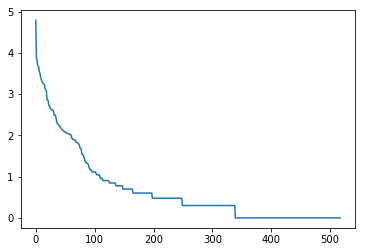

In [219]:
plt.plot(np.log10(gen_counts[ordered_is]))
plt.show()

In [220]:
from itertools import chain, product

mendelian_parents_to_children = {
    (0, 0): [0],
    (0, 1): [0, 1],
    (0, 2): [1],
    (1, 0): [0, 1],
    (1, 1): [0, 1, 2],
    (1, 2): [1, 2],
    (2, 0): [1],
    (2, 1): [1, 2],
    (2, 2): [2]
}

def generate_mendelian_genotypes(): 
    for par, possible_children in mendelian_parents_to_children.items():
        for child_gens in product(*[possible_children]*5):
            yield par + tuple(child_gens)
        
mg = set(generate_mendelian_genotypes())
print('Mendelian', len(mg))

deletion_parents_to_children = {
    (0, 0, 0, 1): [0],
    (0, 0, 1, 0): [0],
    (0, 0, 1, 1): [-1, 0],
    (0, 1, 1, 0): [0, 1, 2],
    (0, 2, 0, 1): [0, 1],
    (0, 2, 1, 0): [1, 2],
    #(0, 2, 1, 1): [-1, 0, 1, 2],
    (1, 0, 0, 1): [0, 1, 2],
    (1, 2, 0, 1): [0, 1, 2],
    (2, 0, 0, 1): [1, 2],
    (2, 0, 1, 0): [0, 1],
    #(2, 0, 1, 1): [-1, 0, 1, 2],
    (2, 1, 1, 0): [0, 1, 2],
    (2, 2, 0, 1): [2],
    (2, 2, 1, 0): [2],
    (2, 2, 1, 1): [-1, 2]
}

def generate_deletion_genotypes(): 
    for par, possible_children in deletion_parents_to_children.items():
        for child_gens in product(*[possible_children]*5):
            yield par[:2] + tuple(child_gens)
        
dg = set(generate_deletion_genotypes())-mg
print('Deletion', len(dg))

Mendelian 375
Deletion 1030


In [197]:
gen_to_count = dict(zip(map(tuple, gens.T), gen_counts))

In [198]:
print(gen_to_count[(0,)*7]/sum(gen_counts))

0.4643738465780933


In [205]:
included_gens = mg
print(len(included_gens), sum([gen_to_count[g] for g in included_gens if g in gen_to_count])/np.sum(gen_counts))

#included_gens = dg | included_gens
#print(len(included_gens), sum([gen_to_count[g] for g in included_gens if g in gen_to_count])/np.sum(gen_counts))

included_gens = set(map(tuple, homref_missing)) | included_gens
print(len(included_gens), sum([gen_to_count[g] for g in included_gens if g in gen_to_count])/np.sum(gen_counts))

included_gens = set(map(tuple, np.eye(7, dtype=np.int8))) | included_gens
print(len(included_gens), sum([gen_to_count[g] for g in included_gens if g in gen_to_count])/np.sum(gen_counts))


375 0.9079807957462154
502 0.9645895055399606
507 0.9770835837569912


In [178]:
print(sorted([(k, v) for k, v in gen_to_count.items() if k not in included_gens], reverse=True, key=lambda x: x[1]))

[((0, 0, 1, 0, 1, 0, 0), 119), ((0, 0, 0, 0, 0, 1, 1), 106), ((0, 0, 0, 1, 1, 0, 0), 105), ((0, 0, 1, 0, 0, 0, 1), 57), ((0, 0, 1, 0, 0, 1, 1), 57), ((0, 0, 1, 1, 1, 0, 0), 50), ((0, 0, 1, 0, 0, 1, 0), 49), ((0, 0, 1, 1, 0, 0, 0), 45), ((2, 0, 0, 0, 0, 1, 1), 44), ((0, 0, 0, 1, 0, 1, 1), 43), ((2, 0, 1, 1, 1, 0, 0), 43), ((0, 0, 0, 1, 0, 1, 0), 39), ((0, 0, 0, 0, 1, 1, 0), 32), ((0, 0, 0, 0, 1, 1, 1), 32), ((0, 0, 0, 1, 1, 1, 0), 27), ((0, 0, 0, 1, 0, 0, 1), 24), ((0, 0, 1, 1, 1, 1, 1), 20), ((0, 0, 0, 0, 1, 0, 1), 19), ((0, 0, 1, 0, 1, 0, 1), 17), ((0, 0, 1, 1, 0, 1, 0), 17), ((2, 0, 1, 0, 1, 1, 1), 16), ((2, 2, 2, -1, 2, 2, 2), 16), ((0, 0, 0, 1, 1, 1, 1), 15), ((0, 0, 1, 0, 1, 1, 1), 15), ((2, 0, 0, 0, 0, 0, 0), 15), ((0, 0, 1, 0, 1, 1, 0), 14), ((2, 1, 0, 2, 1, 2, 2), 14), ((0, 0, 1, 1, 0, 0, 1), 13), ((0, 1, 0, -1, 0, 0, 0), 13), ((0, 1, 2, 0, 1, 0, 0), 13), ((-1, -1, -1, -1, 1, -1, -1), 12), ((-1, 2, -1, -1, -1, -1, -1), 12), ((0, 0, 0, 0, 0, -1, 2), 12), ((0, 0, 0, 2, 0, 0, 0), 